No GPU available, using the CPU instead.


Epitope                              \
                         Epitope IRI     Object Type Description   
0    http://www.iedb.org/epitope/551  Linear peptide  ACDPHSGHFV   
1  http://www.iedb.org/epitope/12941  Linear peptide  ELAGIGILTV   
2  http://www.iedb.org/epitope/27469  Linear peptide   IMDQVPFSV   
3  http://www.iedb.org/epitope/59276  Linear peptide   SLLMWITQA   
4  http://www.iedb.org/epitope/59283  Linear peptide   SLLMWITQV   

                                                                         \
  Epitope Modified Residue(s) Epitope Modification(s) Starting Position   
0                         NaN                     NaN               NaN   
1                         NaN                     NaN               NaN   
2                         NaN                     NaN               NaN   
3                         NaN                     NaN               NaN   
4                         NaN                     NaN               NaN   

                                                                          ...  \
  Ending Position Non-peptidic epitope IRI Epitope Synonyms Antigen Name  ...   
0             NaN                      NaN              NaN          NaN  ...   
1             NaN                      NaN              NaN          NaN  ...   
2             NaN                      NaN              NaN          NaN  ...   
3             NaN                      NaN              NaN          NaN  ...   
4             NaN                      NaN              NaN          NaN  ...   

           Related Object                                                     \
  Non-peptidic object IRI                                           Synonyms   
0                     NaN                     cell division protein kinase 4   
1                     NaN  Antigen LB39-AA, Antigen SK29-AA, Protein Mela...   
2                     NaN  ME20-M, Melanocyte protein Pmel 17, Melanocyte...   
3                     NaN                                                NaN   
4                     NaN                                           NY-ESO-1   

                                             \
                               Antigen Name   
0                 cyclin-dependent kinase 4   
1  Melanoma antigen recognized by T-cells 1   
2                   Melanocyte protein PMEL   
3                   Cancer/testis antigen 1   
4                          NY-ESO-1 protein   

                                                    \
                                       Antigen IRI   
0  http://www.ncbi.nlm.nih.gov/protein/NP_000066.1   
1         https://www.uniprot.org/uniprot/Q16655.1   
2         https://www.uniprot.org/uniprot/P40967.2   
3     http://www.ncbi.nlm.nih.gov/protein/P78358.1   
4   http://www.ncbi.nlm.nih.gov/protein/CAA05908.1   

                                             \
                             Parent Protein   
0                 Cyclin-dependent kinase 4   
1  Melanoma antigen recognized by T-cells 1   
2                   Melanocyte protein PMEL   
3                   Cancer/testis antigen 1   
4                   Cancer/testis antigen 1   

                                                                \
                      Parent Protein IRI         Organism Name   
0  http://www.uniprot.org/uniprot/P11802  Homo sapiens (human)   
1  http://www.uniprot.org/uniprot/Q16655  Homo sapiens (human)   
2  http://www.uniprot.org/uniprot/P40967  Homo sapiens (human)   
3  http://www.uniprot.org/uniprot/P78358  Homo sapiens (human)   
4  http://www.uniprot.org/uniprot/P78358  Homo sapiens (human)   

                                                                  \
                                    Organism IRI Parent Organism   
0  http://purl.obolibrary.org/obo/NCBITaxon_9606    Homo sapiens   
1  http://purl.obolibrary.org/obo/NCBITaxon_9606    Homo sapiens   
2  http://purl.obolibrary.org/obo/NCBITaxon_9606    Homo sapiens   
3  http://purl.obolibrary.org/obo/NCBITaxon_9606    Hom

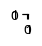

In [8]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import dataframe_image as dfi
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 180
sns.set_style('darkgrid')
import os,sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings("ignore")

from tqdm.auto import tqdm
from datetime import datetime as dt
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, display_side, add_median_labels
from src.data_processing import get_dataset, BL62_VALUES, BL62FREQ_VALUES, HLAS, AA_KEYS
from src.metrics import get_predictions, get_roc, get_metrics, plot_roc_auc_fold, get_mean_roc_curve
from src.metrics import get_nested_feature_importance, plot_feature_importance
from src.partition_tools import pipeline_stratified_kfold
from src.utils import pkl_load, pkl_dump
from src.baselines import plot_baseline_roc, plot_related_baseline_roc
from src.models import FFNetPipeline

PAL = sns.color_palette('hsv', n_colors=13)
HSV = [PAL[-4], PAL[-1], PAL[0], PAL [4]]
mpl.rcParams['figure.dpi'] = 180

import torch
from torch import optim, nn
import torch.functional as F
from torch.utils.data import DataLoader, TensorDataset

if torch.cuda.is_available():
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name())
    device="cuda:0"
else:
    print('No GPU available, using the CPU instead.')
    device='cpu'

In [9]:
from src.utils import flatten_level_columns

In [12]:
  newepi = pd.read_csv('../../epitope_table_export_1675359257.csv', header=[0,1])
newepi = flatten_level_columns(newepi)
newepi.columns 

Index(['epitope_epitope iri', 'epitope_object type', 'epitope_description',
       'epitope_epitope modified residue(s)',
       'epitope_epitope modification(s)', 'epitope_starting position',
       'epitope_ending position', 'epitope_non-peptidic epitope iri',
       'epitope_epitope synonyms', 'epitope_antigen name',
       'epitope_antigen iri', 'epitope_parent protein',
       'epitope_parent protein iri', 'epitope_organism name',
       'epitope_organism iri', 'epitope_parent organism',
       'epitope_parent organism iri', 'epitope_epitope comments',
       'related object_epitope relationship', 'related object_object type',
       'related object_description', 'related object_starting position',
       'related object_ending position',
       'related object_non-peptidic object iri', 'related object_synonyms',
       'related object_antigen name', 'related object_antigen iri',
       'related object_parent protein', 'related object_parent protein iri',
       'related object_or

In [23]:
from src.mutation_tools import pipeline_mutation_scores
len(newepi.epitope_description.unique())

5154

In [24]:
newepi

,epitope_epitope iri,epitope_object type,epitope_description,epitope_epitope modified residue(s),epitope_epitope modification(s),epitope_starting position,epitope_ending position,epitope_non-peptidic epitope iri,epitope_epitope synonyms,epitope_antigen name,...,related object_non-peptidic object iri,related object_synonyms,related object_antigen name,related object_antigen iri,related object_parent protein,related object_parent protein iri,related object_organism name,related object_organism iri,related object_parent organism,related object_parent organism iri
0,http://www.iedb.org/epitope/551,Linear peptide,ACDPHSGHFV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,cell division protein kinase 4,cyclin-dependent kinase 4,http://www.ncbi.nlm.nih.gov/protein/NP_000066.1,Cyclin-dependent kinase 4,http://www.uniprot.org/uniprot/P11802,Homo sapiens (human),http://purl.obolibrary.org/obo/NCBITaxon_9606,Homo sapiens,http://purl.obolibrary.org/obo/NCBITaxon_9606
1,http://www.iedb.org/epitope/12941,Linear peptide,ELAGIGILTV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,"Antigen LB39-AA, Antigen SK29-AA, Protein Mela...",Melanoma antigen recognized by T-cells 1,https://www.uniprot.org/uniprot/Q16655.1,Melanoma antigen recognized by T-cells 1,http://www.uniprot.org/uniprot/Q16655,Homo sapiens (human),http://purl.obolibrary.org/obo/NCBITaxon_9606,Homo sapiens,http://purl.obolibrary.org/obo/NCBITaxon_9606
2,http://www.iedb.org/epitope/27469,Linear peptide,IMDQVPFSV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,"ME20-M, Melanocyte protein Pmel 17, Melanocyte...",Melanocyte protein PMEL,https://www.uniprot.org/uniprot/P40967.2,Melanocyte protein PMEL,http://www.uniprot.org/uniprot/P40967,Homo sapiens (human),http://purl.obolibrary.org/obo/NCBITaxon_9606,Homo sapiens,http://purl.obolibrary.org/obo/NCBITaxon_9606
3,http://www.iedb.org/epitope/59276,Linear peptide,SLLMWITQA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Cancer/testis antigen 1,http://www.ncbi.nlm.nih.gov/protein/P78358.1,Cancer/testis antigen 1,http://www.uniprot.org/uniprot/P78358,Homo sapiens (human),http://purl.obolibrary.org/obo/NCBITaxon_9606,Homo sapiens,http://purl.obolibrary.org/obo/NCBITaxon_9606
4,http://www.iedb.org/epitope/59283,Linear peptide,SLLMWITQV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NY-ESO-1,NY-ESO-1 protein,http://www.ncbi.nlm.nih.gov/protein/CAA05908.1,Cancer/testis antigen 1,http://www.uniprot.org/uniprot/P78358,Homo sapiens (human),http://purl.obolibrary.org/obo/NCBITaxon_9606,Homo sapiens,http://purl.obolibrary.org/obo/NCBITaxon_9606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5149,http://www.iedb.org/epitope/2151075,Linear peptide,SPMIVGSPW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,myeloid upregulated protein,myeloid-associated differentiation marker,http://www.ncbi.nlm.nih.gov/protein/NP_612382.1,Myeloid-associated differentiation marker,http://www.uniprot.org/uniprot/Q96S97,Homo sapiens (human),http://purl.obolibrary.org/obo/NCBITaxon_9606,Homo sapiens,http://purl.obolibrary.org/obo/NCBITaxon_9606
5150,http://www.iedb.org/epitope/2151076,Linear peptide,SPMIVGSPWA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,myeloid upregulated protein,myeloid-associated differentiation marker,http://www.ncbi.nlm.nih.gov/protein/NP_612382.1,Myeloid-associated differentiation marker,http://www.uniprot.org/uniprot/Q96S97,Homo sapiens (human),http://purl.obolibrary.org/obo/NCBITaxon_9606,Homo sapiens,http://purl.obolibrary.org/obo/NCBITaxon_9606
5151,http://www.iedb.org/epitope/2151077,Linear peptide,SPMIVGSPWAL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,myeloid upregulated protein,myeloid-associated differentiation marker,http://www.ncbi.nlm.nih.gov/protein/NP_612382.1,Myeloid-associated differentiation marker,http://www.uniprot.org/uniprot/Q96S97,Homo sapiens (human),http://purl.obolibrary.org/obo/NCBITaxon_9606,Homo sapiens,http://purl.obolibrary.org/obo/NCBITaxon_9606
5152,http://www.iedb.org/epitope/2151078,Linear peptide,SPWALTQPL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,myeloid upregula

In [39]:
june = pd.read_excel('../../neo_JUN2022_full_res.xlsx', sheet_name='short')
june.groupby(['Epitope_Description', 'MHC_Allele Name','qual']).count()

Related Object_Epitope Relationship  \
Epitope_Description MHC_Allele Name qual                                                
AAAAAAQQIQV         HLA-B*07:02     Negative                                        1   
AAAAQQIQV           HLA-A*02:01     Negative                                        1   
                    HLA-B*07:02     Negative                                        1   
AAFIWIISM           HLA-B*35:01     Negative                                        1   
AAHFTVLLY           HLA-A*11:01     Negative                                        1   
...                                                                               ...   
YYPGKKEPF           HLA-A*24:02     Negative                                        2   
YYPPSQIAQL          HLA-A*24:02     Positive_all                                    1   
YYSKNLNSF           HLA-A*24:02     Positive_all                                    1   
YYSKNLNSFF          HLA-A*24:02     Positive_all                                    2   
YYSPQAQTL           HLA-A*24:02     Negative                                        1   

                                                  Related Object_Object Type  \
Epitope_Description MHC_Allele Name qual                                       
AAAAAAQQIQV         HLA-B*07:02     Negative                               1   
AAAAQQIQV           HLA-A*02:01     Negative                               1   
                    HLA-B*07:02     Negative                               1   
AAFIWIISM           HLA-B*35:01     Negative                               1   
AAHFTVLLY           HLA-A*11:01     Negative                               1   
...                                                                      ...   
YYPGKKEPF           HLA-A*24:02     Negative                               2   
YYPPSQIAQL          HLA-A*24:02     Positive_all                           1   
YYSKNLNSF           HLA-A*24:02     Positive_all                           1   
YYSKNLNSFF          HLA-A*24:02     Positive_all                           2   
YYSPQAQTL           HLA-A*24:02     Negative                               1   

                                                  Related Object_Description  \
Epitope_Description MHC_Allele Name qual                                       
AAAAAAQQIQV         HLA-B*07:02     Negative                               1   
AAAAQQIQV           HLA-A*02:01     Negative                               1   
                    HLA-B*07:02     Negative                               1   
AAFIWIISM           HLA-B*35:01     Negative                               1   
AAHFTVLLY           HLA-A*11:01     Negative                               1   
...                                                                      ...   
YYPGKKEPF           HLA-A*24:02     Negative                               2   
YYPPSQIAQL          HLA-A*24:02     Positive_all                           1   
YYSKNLNSF           HLA-A*24:02     Positive_all                           1   
YYSKNLNSFF          HLA-A*24:02     Positive_all                           2   
YYSPQAQTL           HLA-A*24:02     Negative                               1   

                                                  check_length  \
Epitope_Description MHC_Allele Name qual                         
AAAAAAQQIQV         HLA-B*07:02     Negative                 1   
AAAAQQIQV           HLA-A*02:01     Negative                 1   
                    HLA-B*07:02     Negative                 1   
AAFIWIISM           HLA-B*35:01     Negative                 1   
AAHFTVLLY           HLA-A*11:01     Negative                 1   
...                                                        ...   
YYPGKKEPF           HLA-A*24:02     Negative                 2   
YYPPSQIAQL          HLA-A*24:02     Positive_all             1   
YYSKNLNSF           HLA-A*24:02     Positive_all             1   
YYSKNLNSFF          HLA-A*24:02     Positive_all             2   
YYSPQAQTL         

In [40]:
len(june)

5773

In [42]:
june.query('Epitope_Description=="YYPGKKEPF"')

,Epitope_Description,Related Object_Epitope Relationship,Related Object_Object Type,Related Object_Description,check_length,Related Object_Starting Position,Related Object_Ending Position,Related Object_Parent Protein,Related Object_Parent Protein IRI,1st in vivo Process_Disease State,Assay_Method/Technique,Assay_Assay Group,Assay_Qualitative Measure,Effector Cells_Cell Type,MHC_Allele Name,qual
4244,YYPGKKEPF,neo-epitope,Fragment of a Natural Sequence Molecule,YYSGKKEPF,True,260.0,268.0,Cytochrome c oxidase subunit 1,http://www.uniprot.org/uniprot/P00395,hepatocellular carcinoma,multimer/tetramer,qualitative binding,Negative,Hepatocyte,HLA-A*24:02,Negative
4245,YYPGKKEPF,neo-epitope,Fragment of a Natural Sequence Molecule,YYSGKKEPF,True,260.0,268.0,Cytochrome c oxidase subunit 1,http://www.uniprot.org/uniprot/P00395,healthy,multimer/tetramer,qualitative binding,Negative,Hepatocyte,HLA-A*24:02,Negative
